In [1]:
# Mount Google Grive for Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# # Get the data from drive
# ! cp /content/drive/My\ Drive/Datasets/facial-keypoints-detection.zip /content
# ! unzip facial-keypoints-detection.zip
# ! rm -rf sample_data
# ! rm -rf facial-keypoints-detection.zip
# ! unzip training.zip
# ! unzip test.zip
# ! rm -rf training.zip
# ! rm -rf test.zip

In [0]:
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')

In [5]:
# Print training data head
train_df.drop(['Image'], axis = 1).tail()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.265961,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.910346,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.754202,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447
7048,66.938311,43.424510,31.096059,39.528604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.069250,73.033339,NaN,NaN,NaN,NaN,NaN,NaN,45.900480,82.773096


In [6]:
train_df.shape

(7049, 31)

In [0]:
# constants
IMG_SIZE = 96
N_KEYPOINTS = 30
m = train_df.shape[0]

In [0]:
X_train = train_df['Image']
Y_train = train_df.drop(['Image'], axis = 1)

In [9]:
# check if training data contains NaN
print (Y_train.isnull().values.any())

True


In [0]:
# This contains NaN, replacing those values with mean of corresponding column
if Y_train.isnull().values.any():
    Y_train.fillna(Y_train.mean(), inplace=True)

In [11]:
# Check again for NaN
print (Y_train.isnull().values.any())

False


In [12]:
Y_train.tail()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
7044,67.402546,31.842551,29.746749,38.632942,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.265961,67.029093,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.426637,79.683921
7045,66.134400,38.365501,30.478626,39.950198,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,47.910346,66.626011,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,49.462572,67.515161,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,50.754202,66.724988,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.065186,79.586447
7048,66.938311,43.424510,31.096059,39.528604,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,47.069250,73.033339,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,45.900480,82.773096


In [0]:
# Normalize the data
X_train = X_train.apply(lambda x: np.array(x.split()).astype(int)/255).to_numpy()
Y_train = Y_train.apply(lambda x: x / IMG_SIZE).to_numpy()

In [0]:
X_train = np.stack(X_train, axis = 0)

In [15]:
print (X_train.shape)
print (Y_train.shape)
# Shapes are (m, # of features) and (m, # of keypoints)

(7049, 9216)
(7049, 30)


In [0]:
# split train and validation set data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.20)

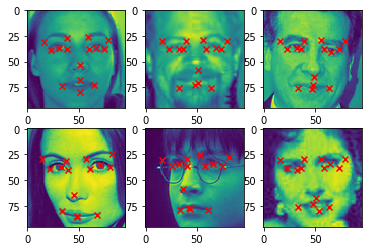

In [17]:
# Plot a few training images
_, ax = plt.subplots(nrows = 2, ncols = 3)
count = 0
for row in ax:
    for col in row:
        col.imshow(X_train[count].reshape(IMG_SIZE, IMG_SIZE))
        col.scatter((np.take(Y_train[count], range(0, N_KEYPOINTS, 2))) * IMG_SIZE, (np.take(Y_train[count], range(1, N_KEYPOINTS, 2))) * IMG_SIZE, color = 'red', marker = 'x')
        count += 1

plt.show()

In [0]:
def initialize_params(input_size, hidden_layers, n_classes):

    # tf.reset_default_graph()
    params = {}
    hidden_layers.insert(0, input_size)
    hidden_layers.append(n_classes)

    for layer in range(len(hidden_layers) - 1):
        params[layer] = {}
        params[layer][f'W{layer}'] = tf.get_variable(name = f'W{layer}', shape = [hidden_layers[layer + 1], hidden_layers[layer]], initializer = tf.contrib.layers.xavier_initializer(seed=28))
        params[layer][f'b{layer}'] = tf.get_variable(name = f'b{layer}', shape = [1, hidden_layers[layer + 1]], initializer = tf.zeros_initializer())
    
    return params
        

In [0]:
def calculate_cost(logits, labels):
    # This is a regression problem and thus we can not use categorial cross entropy log loss as it's suitable for classification problem    
    # return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits))
    return tf.reduce_mean(tf.squared_difference(tf.squeeze(labels), tf.squeeze(logits)))

In [0]:
def get_placeholders(n_features, n_outputs):
    X = tf.placeholder(name='X', shape=[None, n_features], dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape = [None, n_outputs], dtype=tf.float32)
    
    return X, Y

In [0]:
def get_minibatches(X, Y, batch_size = 64):
    
    assert X.shape[0] == Y.shape[0]
    
    shuffeled_indices = np.random.RandomState(seed=0).permutation(X.shape[0])
    X_shuffeled = X[shuffeled_indices]
    Y_shuffeled = Y[shuffeled_indices]
    
    complete_batches = X.shape[0] // batch_size
    X_batches, Y_batches = [], []
    
    # First create all complete batches of size "batch_size"
    for batch in range(complete_batches):
        X_batches.append(X_shuffeled[batch * batch_size : (batch + 1) * batch_size])
        Y_batches.append(Y_shuffeled[batch * batch_size : (batch + 1) * batch_size])
        
    # In case of incomplete last batch
    if X.shape[0] % batch_size != 0:
        X_batches.append(X_shuffeled[batch_size * complete_batches : ])
        Y_batches.append(Y_shuffeled[batch_size * complete_batches : ])
        
    return X_batches, Y_batches

In [0]:
def forward_propagate(X, params):
    
    A_prev = X
    
    for layer, param in params.items():
        Z = tf.add(tf.matmul(A_prev, tf.transpose(param['W' + str(layer)])), param['b' + str(layer)])
        A_prev = tf.nn.relu(Z)
    
    # Returning logits instead of activations of last layer as softmax cross entropy requires logits
    return Z

In [0]:
def get_validation_cost(tf_session, params, X_valid, Y_valid):
    X_valid_placeholder = tf.placeholder(name='X_valid_ph', shape=[None, IMG_SIZE * IMG_SIZE], dtype=tf.float32)
    Y_valid_placeholder = tf.placeholder(name='Y_valid_ph', shape=[None, N_KEYPOINTS], dtype = tf.float32)
    Z = forward_propagate(X_valid_placeholder, params)
    cost = calculate_cost(Z, Y_valid_placeholder)
    return tf_session.run(cost, feed_dict={X_valid_placeholder: X_valid, Y_valid_placeholder: Y_valid})

In [0]:
def predict(trained_params, X):
    X_predict = tf.placeholder(name='X_pred', shape=[None, IMG_SIZE * IMG_SIZE], dtype=tf.float32)
    Z = forward_propagate(X_predict, trained_params)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        return session.run(tf.nn.relu(Z), feed_dict={X_predict: X})

In [0]:
def model(X_train, Y_train, X_valid, Y_valid, learning_rate = 0.01, batch_size = 64, epochs = 1000):
    
    # Reset the graph
    tf.reset_default_graph()
    
    # Build tensorflow graph
    X, Y = get_placeholders(IMG_SIZE * IMG_SIZE, N_KEYPOINTS)
    params = initialize_params(IMG_SIZE * IMG_SIZE, [100], N_KEYPOINTS)
    Z_L = forward_propagate(X, params)
    cost = calculate_cost(Z_L, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    train_costs, valid_costs = [], []
    with tf.Session() as session:
        
        session.run(tf.global_variables_initializer())
        
        # Run gradiant descent over "epochs" epochs
        for epoch in range(epochs):
            
            n_minibatches, batch_cost = m // batch_size, 0
            
            # Divide the data in mini-batches of given size
            X_minibatches, Y_minibatches = get_minibatches(X_train, Y_train, batch_size = batch_size)
            
            # For each mini batch, take a step of gradiant descent
            for X_minibatch, Y_minibatch in zip(X_minibatches, Y_minibatches):
                _, minibatch_cost = session.run([optimizer, cost], feed_dict = {X: X_minibatch, Y: Y_minibatch})
                batch_cost += minibatch_cost / n_minibatches        
            
            validation_cost = get_validation_cost(session, params, X_valid, Y_valid)
            train_costs.append(batch_cost)
            valid_costs.append(validation_cost)
            print (f'Error after {epoch} epochs: Training error: {batch_cost}, Validation set error: {validation_cost}')
                     
            
        return train_costs, valid_costs, session.run(params)    

In [45]:
train_costs, valid_costs, trained_params = model(X_train, Y_train, X_valid, Y_valid, learning_rate = 0.01, batch_size = 128, epochs = 100)

Error after 0 epochs: Training error: 35.87947759194806, Validation set error: 0.28550928831100464
Error after 1 epochs: Training error: 0.21056940691037607, Validation set error: 0.22716397047042847
Error after 2 epochs: Training error: 0.16295943476937033, Validation set error: 0.17148402333259583
Error after 3 epochs: Training error: 0.12110251540487459, Validation set error: 0.1255073994398117
Error after 4 epochs: Training error: 0.08769830844619056, Validation set error: 0.08994898945093155
Error after 5 epochs: Training error: 0.06235674592581661, Validation set error: 0.06347683817148209
Error after 6 epochs: Training error: 0.04372507198290391, Validation set error: 0.04426306486129761
Error after 7 epochs: Training error: 0.03032686632465233, Validation set error: 0.03058316931128502
Error after 8 epochs: Training error: 0.020859805325215506, Validation set error: 0.020997168496251106
Error after 9 epochs: Training error: 0.014269176311790937, Validation set error: 0.01437149

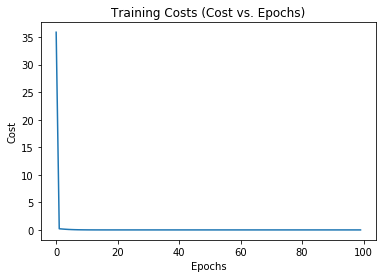

In [46]:
plt.plot(train_costs)
plt.title('Training Costs (Cost vs. Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

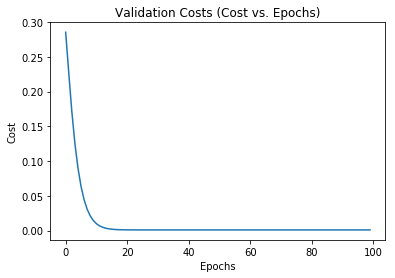

In [47]:
plt.plot(valid_costs)
plt.title('Validation Costs (Cost vs. Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

Y_pred: [0.6912983  0.39200842 0.3153174  0.3948635  0.6159475  0.39528796
 0.76273555 0.39279327 0.38171518 0.39560792 0.23327677 0.39601055
 0.5836397  0.30546564 0.82771057 0.31084037 0.40947706 0.30739316
 0.16530202 0.31687534 0.5036036  0.65211123 0.65917706 0.7916732
 0.34285057 0.7937056  0.49960926 0.7599428  0.505925   0.82374996]
Y_valid: [0.69513043 0.36847029 0.32918116 0.38142391 0.63683333 0.37818551
 0.75665942 0.36523188 0.39718841 0.39113913 0.25793478 0.38142391
 0.62712319 0.32313188 0.80523913 0.29398551 0.40042754 0.33608551
 0.22231159 0.33932391 0.51053623 0.62107246 0.68865217 0.7506087
 0.36804348 0.7506087  0.51701449 0.7506087  0.51377536 0.83481159]


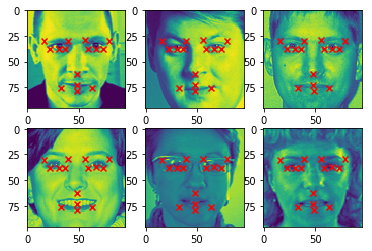

In [62]:
# First predict all Y_valid
Y_preds = predict(trained_params, X_valid)
print (f'Y_pred: {Y_preds[0]}')
print (f'Y_valid: {Y_valid[0]}')

# Plot a few training images
_, ax = plt.subplots(nrows = 2, ncols = 3)
count = 0
for row in ax:
    for col in row:
        col.imshow(X_valid[count].reshape(IMG_SIZE, IMG_SIZE))
        col.scatter((np.take(Y_preds[count], range(0, N_KEYPOINTS, 2))) * IMG_SIZE, (np.take(Y_preds[count], range(1, N_KEYPOINTS, 2))) * IMG_SIZE, color = 'red', marker = 'x')
        count += 1

plt.show()